## Python Frontend
This notebook demonstrates the Python frontend to MPB.

In [15]:
%load_ext autoreload
%autoreload 2
from mpb import MPB, MultipleMPB
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'cm'
# make sure to not use Level-3 fonts
mpl.rcParams['pdf.fonttype'] = 42
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'
from copy import deepcopy
import math
mpb = MPB()
mpb["ompl.seed"] = -1  # set the seed of the OMPL planners
mpb.set_planners(['rrt_star'])
mpb.set_steer_functions(['car'])

mpb["steer.car_turning_radius"] = 1.0
mpb["steer.sampling_resolution"] = 0.005
mpb["max_planning_time"] = 10
mpb["ompl.geometric_planner_settings.RRTstar.delay_collision_checking"] = "0"
mpb["ompl.geometric_planner_settings.RRTstar.goal_bias"] = "0.05"
mpb["ompl.geometric_planner_settings.RRTstar.informed_sampling"] = "1"

folder_prefix = "/home/ksatyaki/workspace/bench_ws/src/bench-mr/"
mpb["env.collision.robot_shape_source"] = folder_prefix + "maps/simple_robot.yaml"
mpb.set_image_yaml_env(folder_prefix + "maps/office_cubicles.yaml")
cliff_map_file = folder_prefix + "maps/office_cubicles_cliffmap.xml"
intensity_map_file = folder_prefix + "maps/office_cubicles_intensitymap.xml"
gmmt_map_file = folder_prefix + "maps/office_cubicles_gmmtmap.xml"

cost_fns = ["dtc"]
cost_fn_map = { "dtc" : cliff_map_file, "cliff" : cliff_map_file, "intensity": intensity_map_file, "gmmt": gmmt_map_file }

#mpb.set_start(-5.0, 19.0, -math.pi / 4.0)
#mpb.set_goal(19.0, -5.0, -math.pi / 4.0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Lets run some tests on the cubicles map. . .

In [16]:
mpb["mod.weight_dtc"] = 0.5
mpb["mod.weight_cliff"] = 2.5
mpb["mod.weight_gmmt"] = 2.5
mpb["mod.weight_intensity"] = 2.0
mpb.set_start(-5.0, -5.0, math.pi / 4.0)
mpb.set_goal(19.0, 19.0, math.pi / 4.0)

results_folder_prefix = "mod-tests-trial"
import os
try:
    os.mkdir(results_folder_prefix)
except FileExistsError as fxe:
    print("Folder {} exists, not creating...".format(results_folder_prefix))

mpbs = dict()
result_file_names = []
for cost_fn in cost_fns:  
    uniform_mpb = deepcopy(mpb)
    uniform_mpb["ompl.sampler"] = ""
    uniform_mpb["ompl.geometric_planner_settings.RRTstar.informed_sampling"] = "0"
    uniform_mpb.set_id('{}-{}'.format(cost_fn, 'uniform'))
    uniform_mpb["ompl.intensity_map_file_name"] = intensity_map_file
    uniform_mpb["ompl.optimization_objective"] = cost_fn
    uniform_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
    mpbs['{}-{}'.format(cost_fn, 'uniform')] = uniform_mpb
    result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'uniform'))
    
    ellipse_mpb = deepcopy(mpb)
    ellipse_mpb["ompl.sampler"] = "ellipse"
    ellipse_mpb.set_id('{}-{}'.format(cost_fn, 'ellipse'))
    ellipse_mpb["ompl.intensity_map_file_name"] = intensity_map_file
    ellipse_mpb["ompl.optimization_objective"] = cost_fn
    ellipse_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
    ellipse_mpb.set_planners(['informed_rrt_star'])
    mpbs['{}-{}'.format(cost_fn, 'ellipse')] = ellipse_mpb
    result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'ellipse'))

    intensity_mpb = deepcopy(mpb)
    intensity_mpb["ompl.sampler"] = "intensity"
    intensity_mpb.set_id('{}-{}'.format(cost_fn, 'intensity'))
    intensity_mpb["mod.sampling_bias"] = 0.5
    intensity_mpb["ompl.intensity_map_file_name"] = intensity_map_file
    intensity_mpb["ompl.optimization_objective"] = cost_fn
    intensity_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
    mpbs['{}-{}'.format(cost_fn, 'intensity')] = intensity_mpb
    result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'intensity'))

    dijkstra_mpb = deepcopy(mpb)
    dijkstra_mpb["ompl.sampler"] = "dijkstra"
    dijkstra_mpb["mod.dijkstra_cell_size"] = 0.01
    dijkstra_mpb["mod.sampling_bias"] = 0.05
    dijkstra_mpb.set_id('{}-{}'.format(cost_fn, 'dijkstra'))
    dijkstra_mpb["ompl.intensity_map_file_name"] = intensity_map_file
    dijkstra_mpb["ompl.optimization_objective"] = cost_fn
    dijkstra_mpb["mod.mod_file_name"] = cost_fn_map[cost_fn]
    mpbs['{}-{}'.format(cost_fn, 'dijkstra')] = dijkstra_mpb
    result_file_names.append("{}/{}-{}_results.json".format(results_folder_prefix, cost_fn, 'dijkstra'))


Folder mod-tests-trial exists, not creating...


Run the motion planning benchmark:

In [17]:
for key in mpbs:
    mpbs[key].run(id=key, runs=20, subfolder=folder_prefix + "/python/{}".format(results_folder_prefix))

Running MPB with ID dtc-uniform (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-trial/dtc-uniform.log)...


dtc-uniform: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [03:29<00:00, 10.50s/it]


Running MPB with ID dtc-ellipse (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-trial/dtc-ellipse.log)...


dtc-ellipse: 100%|██████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.51s/it]


Running MPB with ID dtc-intensity (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-trial/dtc-intensity.log)...


dtc-intensity: 100%|████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.51s/it]


Running MPB with ID dtc-dijkstra (log file at /home/ksatyaki/workspace/bench_ws/src/bench-mr//python/mod-tests-trial/dtc-dijkstra.log)...


dtc-dijkstra: 100%|█████████████████████████████████████████████████████████████████████| 20/20 [03:30<00:00, 10.53s/it]


In [18]:
MPB.merge(result_file_names, target_filename="{}/combined.json".format(results_folder_prefix, results_folder_prefix), plan_names=list(mpbs.keys()))

Successfully merged [mod-tests-trial/dtc-uniform_results.json, mod-tests-trial/dtc-ellipse_results.json, mod-tests-trial/dtc-intensity_results.json, mod-tests-trial/dtc-dijkstra_results.json] into mod-tests-trial/combined.json.


Visualize the planner trajectories:

Visualizing mod-tests-trial/combined.json


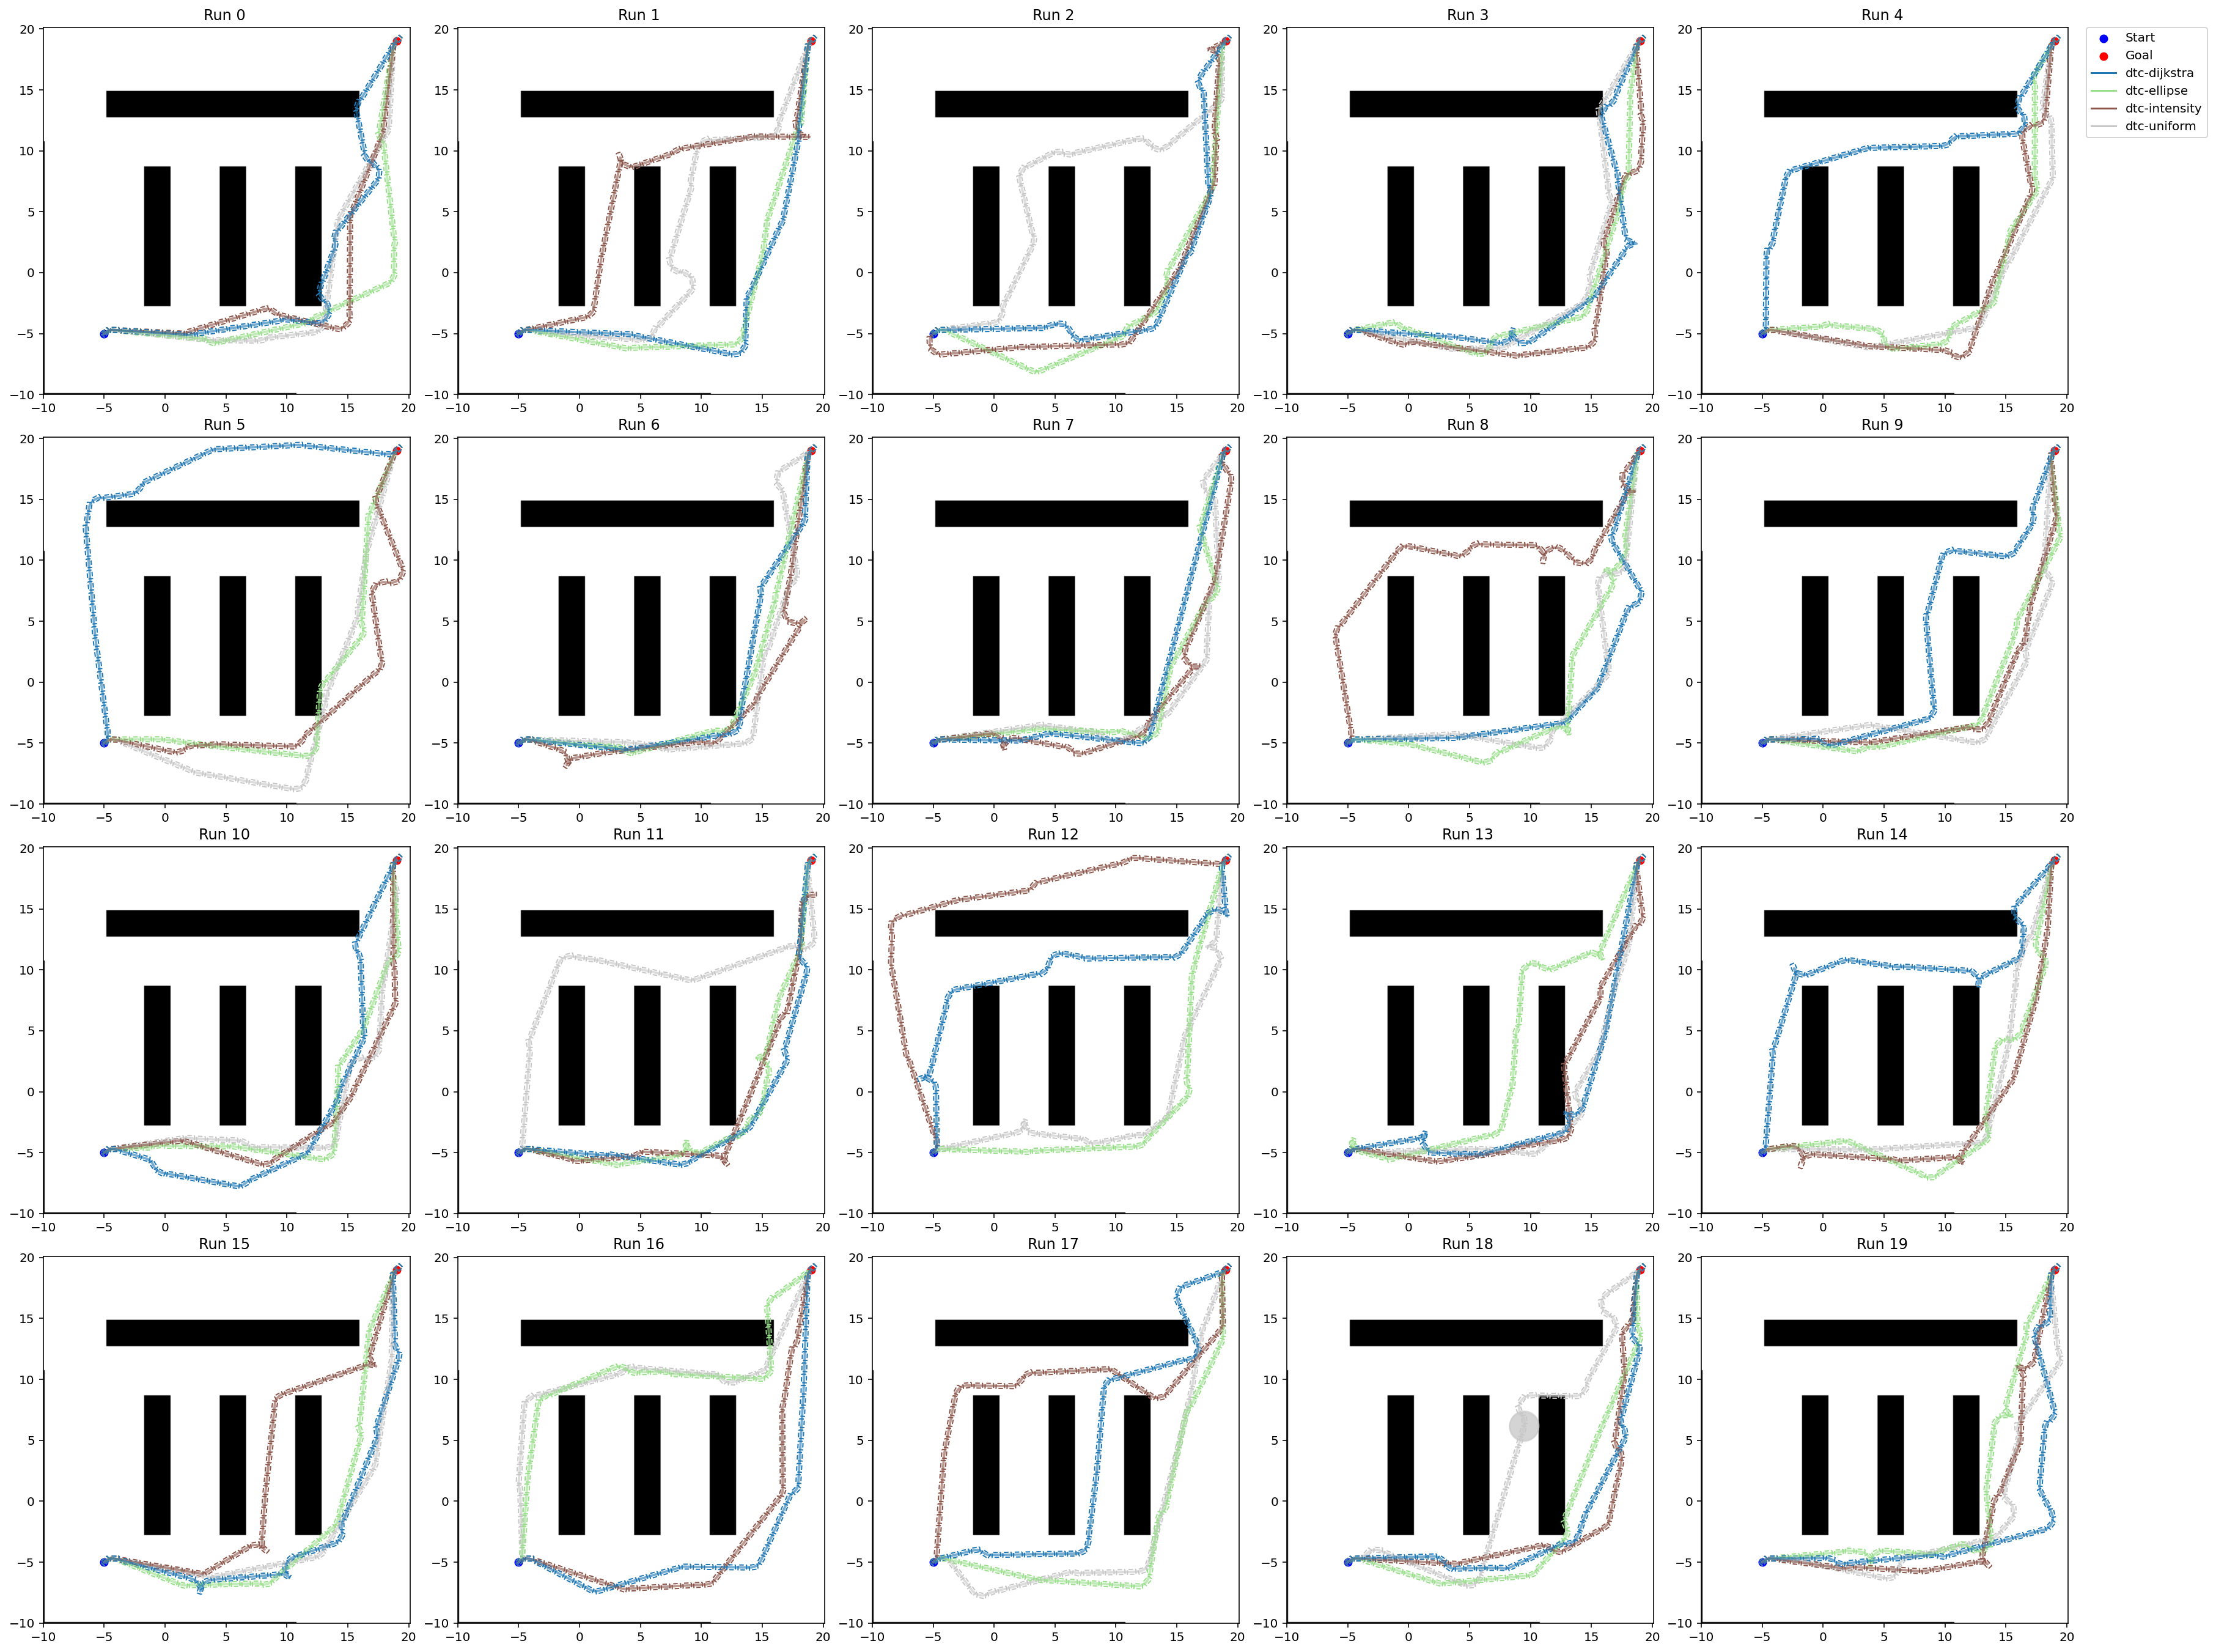

In [19]:
from trajectory import visualize
visualize('{}/combined.json'.format(results_folder_prefix), )

Plot planner statistics:

Visualizing mod-tests-trial/combined.json...


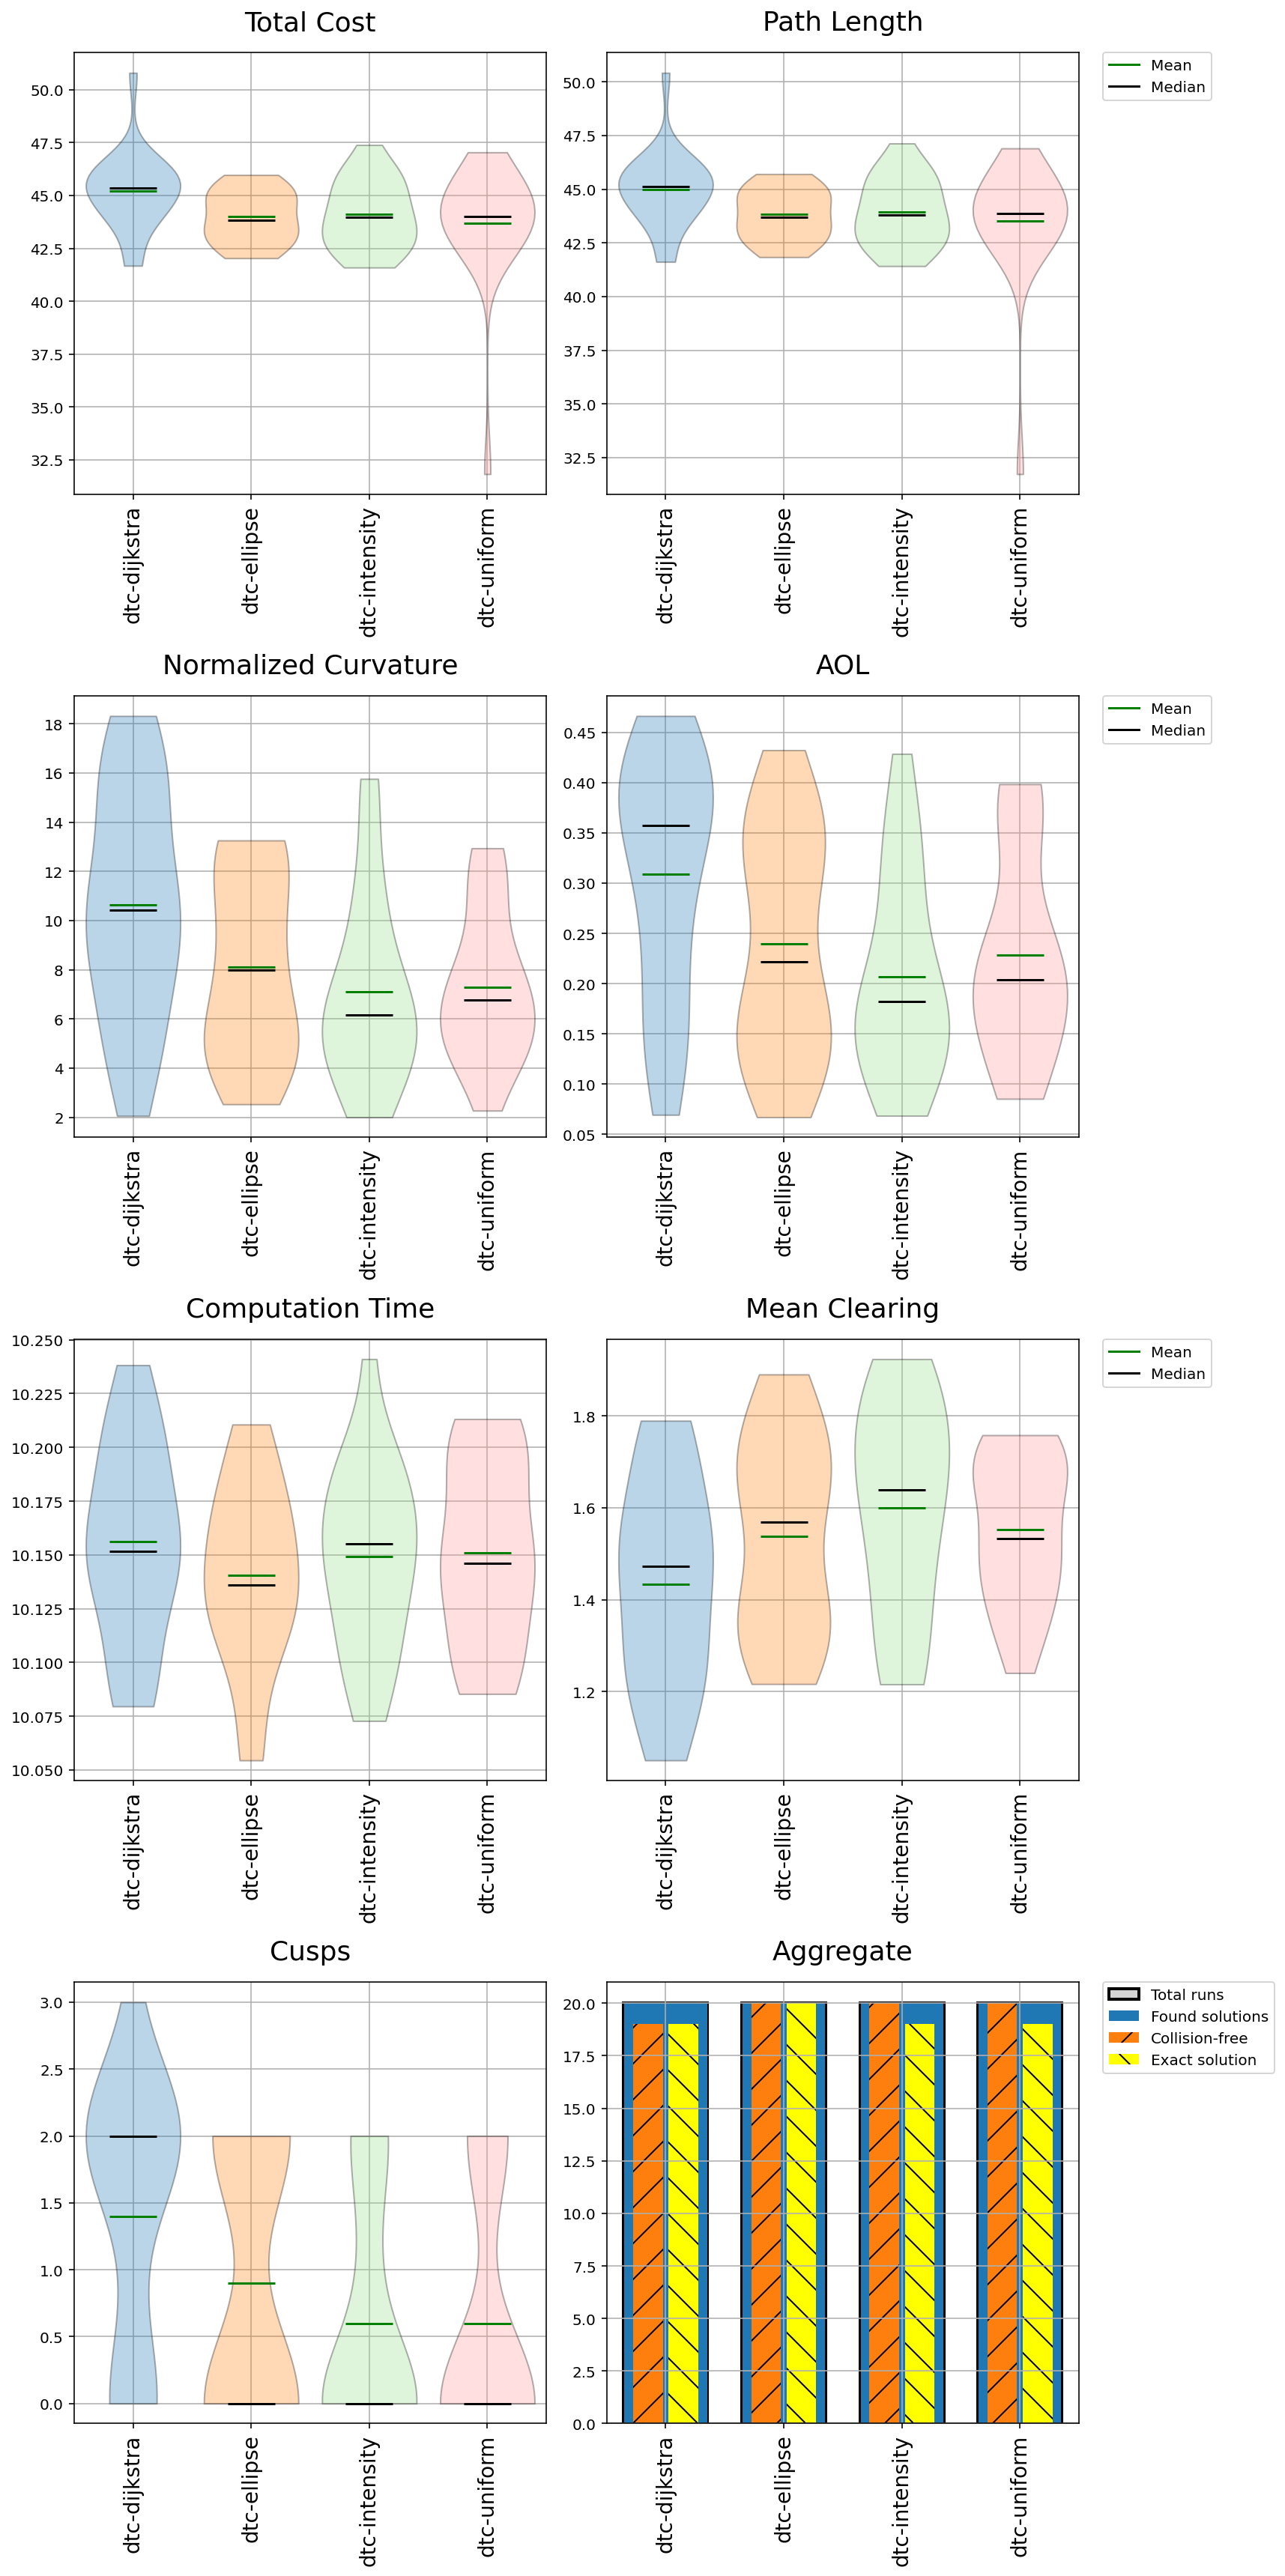

In [14]:
from plot_stats import plot_planner_stats
plot_planner_stats('{}/combined.json'.format(results_folder_prefix), num_colors=8, max_plots_per_line=2, ticks_rotation=90)